<a href="https://colab.research.google.com/github/afriverat25/ImagesProccesDetectionDacky/blob/main/Segmentacion_Dacky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt

144.8794946105349
Se requiere filtro por brillo y sombras 


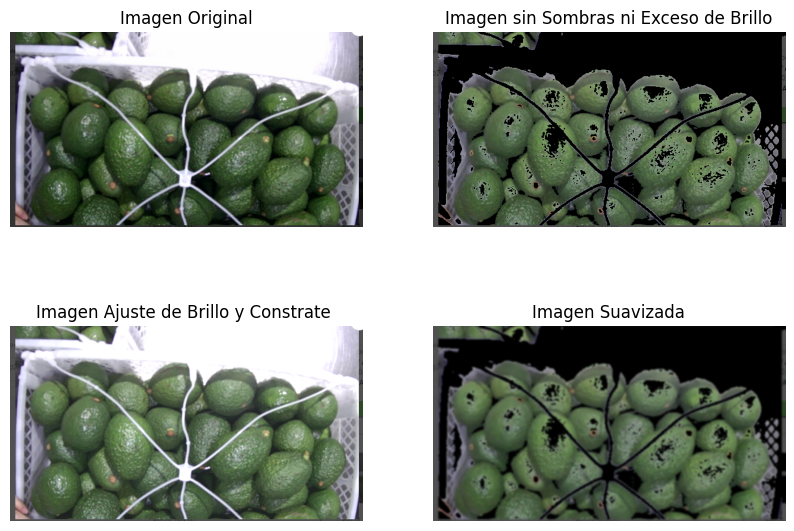

In [ ]:
# Cargar la imagen
image = cv2.imread("/content/Test.png")
#image = cv2.imread("/content/Test_2.png")


# Convertir a RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

alpha = 1.0  # Contraste (1.0 es el valor neutro)
beta = 30   # Brillo (0 es el valor neutro)

imagen_ajustada = cv2.convertScaleAbs(image_rgb, alpha=alpha, beta=beta)

# Convertir la imagen a HSV
image_hsv = cv2.cvtColor(imagen_ajustada, cv2.COLOR_BGR2HSV)

# Extraer el canal de brillo (V)
brightness_channel = image_hsv[:, :, 2]

# Calcular el brillo promedio
average_brightness = np.mean(brightness_channel)

# Definir un umbral de brillo máximo y sombra
max_brightness_threshold = 130  # Ajusta este valor según lo necesario
min_brightness_threshold = 58  # Ajusta este valor según lo necesario
print(average_brightness)
flag = True

# Condición para verificar el brillo y decidir si aplicar el filtro
if  average_brightness < min_brightness_threshold  or  average_brightness > max_brightness_threshold:
    print('Se requiere filtro por brillo y sombras ')

    # Definir rangos para sombras y brillo excesivo
    lower_shadow = np.array([0, 0, 0])
    upper_shadow = np.array([180, 255, 50])

    if  average_brightness > 150 :
      lower_bright = np.array([0, 0, 200])
    else:
      lower_bright = np.array([0, 0, 160])

    upper_bright = np.array([180, 255, 255])

    # Crear máscaras para sombras y brillo
    shadow_mask = cv2.inRange(image_hsv, lower_shadow, upper_shadow)
    bright_mask = cv2.inRange(image_hsv, lower_bright, upper_bright)

    # Unir las máscaras para obtener una única máscara de sombras y brillo
    combined_mask = cv2.bitwise_or(shadow_mask, bright_mask)

    # Invertir la máscara para mantener solo las áreas de interés
    filtered_mask = cv2.bitwise_not(combined_mask)

    # Aplicar la máscara sin sombras y sin brillo en la imagen original
    image_filtered = cv2.bitwise_and(imagen_ajustada, imagen_ajustada, mask=filtered_mask)
    flag = False
else:
    print('No requiere filtro por brillo y sombras ')
    image_filtered = imagen_ajustada


# 2. Aplicación de suavizado (Gaussian Blur)
imagen_suavizada = cv2.GaussianBlur(image_filtered, (7, 7), 0)


plt.figure(figsize=(10, 7))

plt.subplot(2,2,1)
plt.title("Imagen Original")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Imagen sin Sombras ni Exceso de Brillo")
plt.imshow(image_filtered)
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Imagen Ajuste de Brillo y Constrate ")
plt.imshow(imagen_ajustada)
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Imagen Suavizada")
plt.imshow(imagen_suavizada)
plt.axis("off")
plt.show()



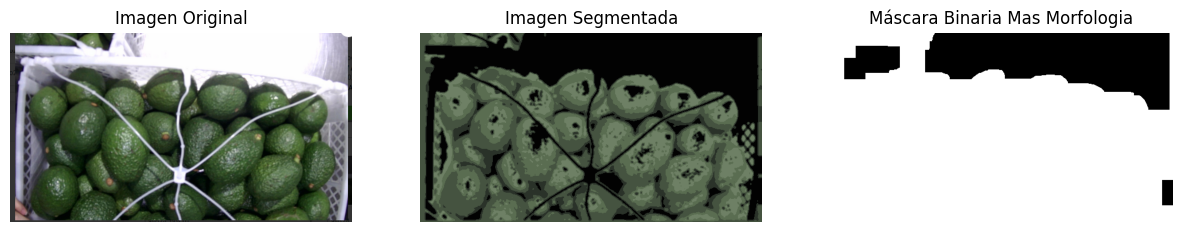

In [ ]:
# Convertir la imagen filtrada a escala de grises y realizar K-means
Z = imagen_suavizada.reshape((-1, 3))
Z = np.float32(Z)
K = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape((image.shape))

# Convertir a escala de grises y crear una máscara binaria
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray_segmented, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Aplicar operaciones morfológicas adicionales

#mask = cv2.bitwise_not(mask)
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (37,37))
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)


plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title("Imagen Original")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Imagen Segmentada")
plt.imshow(segmented_image)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Máscara Binaria Mas Morfologia")
plt.imshow(mask, cmap='gray')
plt.axis("off")


plt.show()


<ipython-input-14-91bb4ed9a939>:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Ajuste no necesario: Bounding Box Detectado


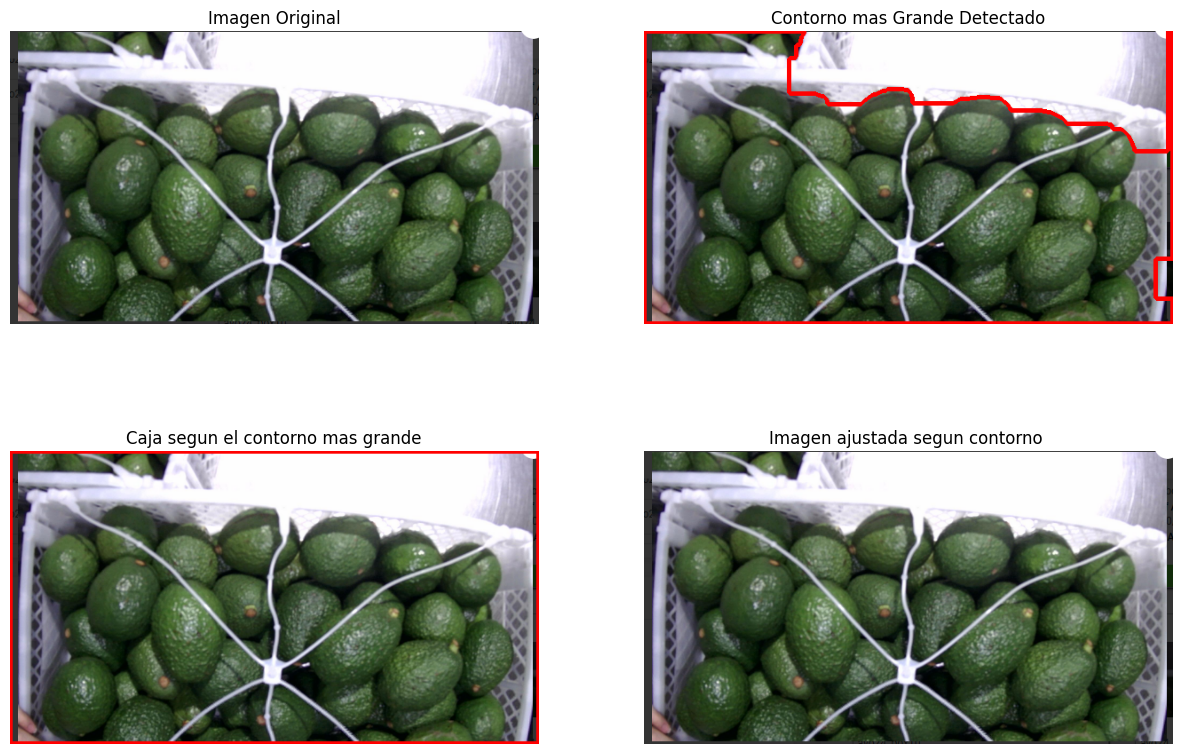

In [ ]:
#Detectar contornos
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour = max(contours, key=cv2.contourArea)  # Seleccionar el contorno más grande

# Encontrar el rectángulo rotado mínimo que encierra el contorno
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)


# Dibujar el contorno y mostrar el área detectada
contour_img = image_rgb.copy()
cv2.drawContours(contour_img, [contour], -1, (255, 0, 0), 3)

# Calcular el bounding box y centrar la imagen
x, y, w, h = cv2.boundingRect(contour)
centered_box_img = image_rgb[y:y+h, x:x+w]

if contours:

    # Dibujar el contorno en la imagen original
    contour_img_box = image_rgb.copy()
    cv2.drawContours(contour_img_box, [box], 0, (255, 0, 0), 3)

    # Verificar si el ajuste es necesario
    original_height, original_width = image.shape[:2]
    _, _, w, h = cv2.boundingRect(contour)
    box_area = w * h
    original_area = original_width * original_height
    adjustment_needed = abs(box_area - original_area) / original_area > 0.05  # Umbral del 5%

    # Mostrar el resultado
    plt.figure(figsize=(15, 10))

    if adjustment_needed:
        print("Ajuste necesario: Bounding Box Detectado")
        plt.subplot(2,2,1)
        plt.title("Imagen Original")
        plt.imshow(image_rgb)
        plt.axis("off")

        plt.subplot(2,2,2)
        plt.title("Contorno mas Grande Detectado")
        plt.imshow(contour_img)
        plt.axis("off")

        plt.subplot(2,2,3)
        plt.title("Caja segun el contorno mas grande")
        plt.imshow(contour_img_box)
        plt.axis("off")

        plt.subplot(2,2,4)
        plt.title("Imagen ajustada segun contorno ")
        plt.imshow(centered_box_img)
        plt.axis("off")

        plt.show()
    else:
        print("Ajuste no necesario: Bounding Box Detectado")
        plt.subplot(2,2,1)
        plt.title("Imagen Original")
        plt.imshow(image_rgb)
        plt.axis("off")

        plt.subplot(2,2,2)
        plt.title("Contorno mas Grande Detectado")
        plt.imshow(contour_img)
        plt.axis("off")

        plt.subplot(2,2,3)
        plt.title("Caja segun el contorno mas grande")
        plt.imshow(contour_img_box)
        plt.axis("off")

        plt.subplot(2,2,4)
        plt.title("Imagen ajustada segun contorno ")
        plt.imshow(centered_box_img)
        plt.axis("off")

        plt.show()
else:
    print("No se detectaron contornos válidos.")

0


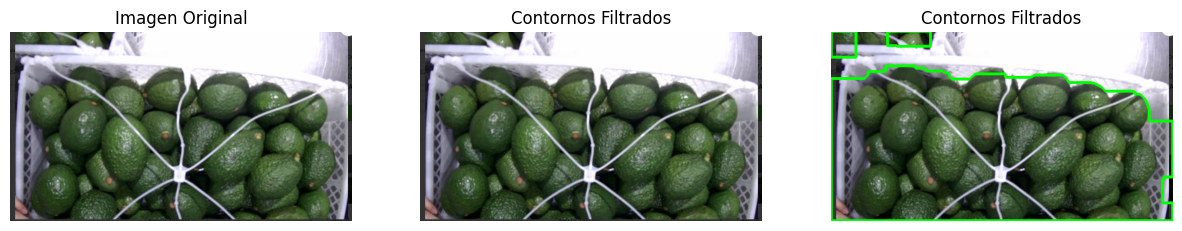

In [ ]:
# Parámetros de filtrado

aspect_ratio_range = (0.1, 2.0)  # Proporción de aspecto esperada
area_range = (5000, 500000)       # Área esperada de la caja

# Identificar posibles contornos de la caja
filtered_contours = []
for contour in contours:
    # Calcular área y bounding box del contorno
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h if h != 0 else 0

    # Aplicar filtros de área y proporción de aspecto
    if area_range[0] < area < area_range[1] and aspect_ratio_range[0] < aspect_ratio < aspect_ratio_range[1]:

        filtered_contours.append(contour)

# Dibujar los contornos filtrados
image_contour_range = image_rgb.copy()
total_contour = image_rgb.copy()
print(len(filtered_contours))
cv2.drawContours(image_contour_range, filtered_contours, -1, (0, 255, 0), 3)
cv2.drawContours(total_contour, contours, -1, (0, 255, 0), 3)
# Mostrar el resultado
plt.figure(figsize=(15, 7))

plt.subplot(1,3,1)
plt.title("Imagen Original")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Contornos Filtrados")
plt.imshow(image_contour_range)
plt.axis("off")


plt.subplot(1,3,3)
plt.title("Contornos Filtrados")
plt.imshow(total_contour)
plt.axis("off")

plt.show()

Dominant Hue: 135
Dominant Color: red
Áreas promedio: 7751.06


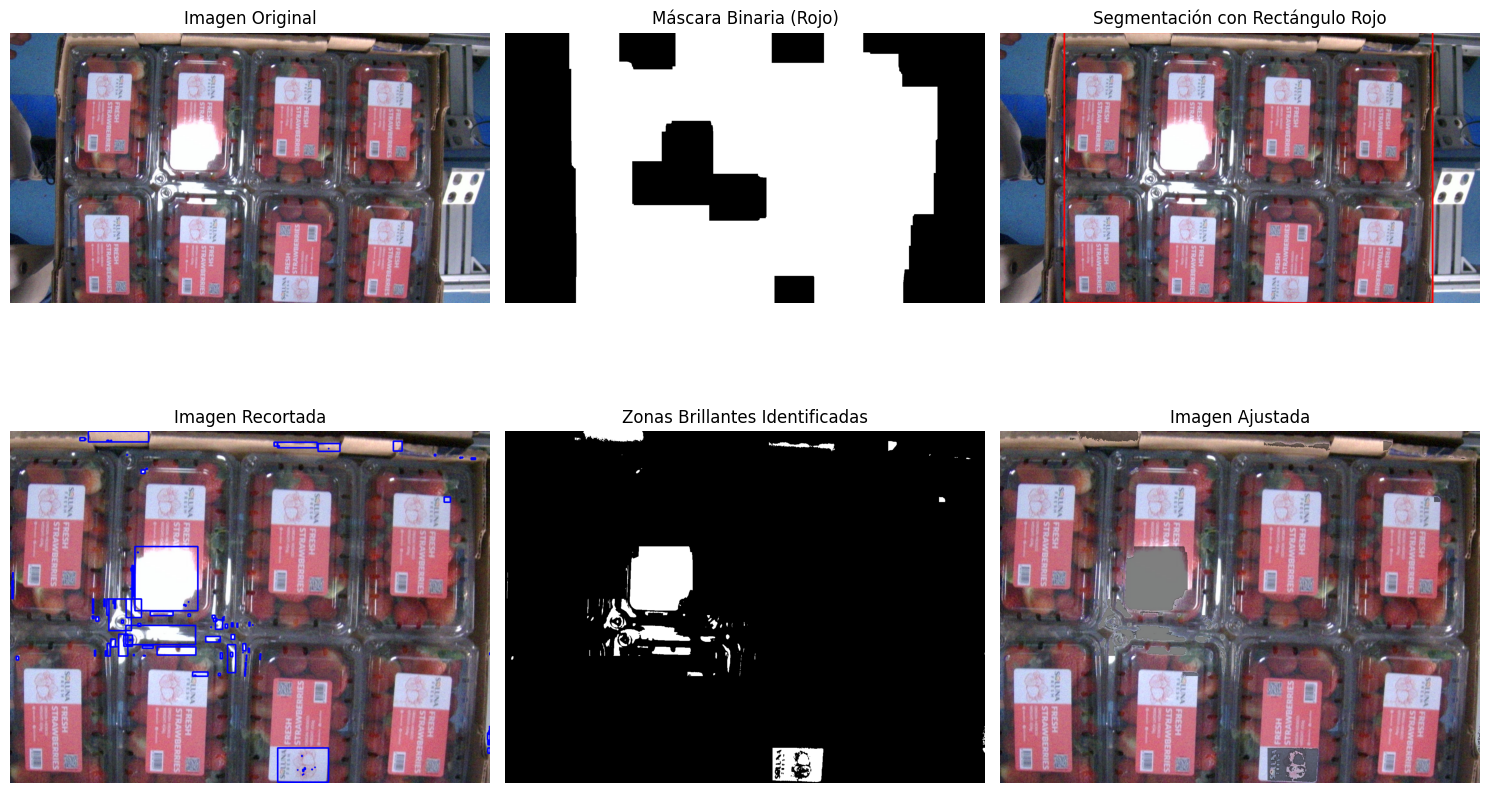

In [ ]:
#image = cv2.imread("/content/Test.png")
image = cv2.imread("/content/Olympic_9.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB para plt
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Convertir la imagen a HSV
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


# Convertir la imagen a un formato adecuado para K-means
pixels = image_hsv.reshape((-1, 3))
pixels = np.float32(pixels)

# Aplicar K-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3  # Número de colores dominantes a identificar
_, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Identificar el centro más frecuente (color dominante)
dominant_color_hsv = centers[np.argmax(np.bincount(labels.flatten()))]
dominant_hue = int(dominant_color_hsv[0])  # Hue del color dominante

print(f"Dominant Hue: {dominant_hue}")

# Definir rangos para colores básicos en HSV
color_ranges = {
    "red": [(0, 100, 100), (10, 255, 255), (160, 100, 100), (179, 255, 255)],  # Dos rangos para rojo
    "yellow": [(25, 50, 50), (35, 255, 255)],
    "green": [(35, 50, 50), (85, 255, 255)],
    "cyan": [(85, 50, 50), (100, 255, 255)],
    "blue": [(100, 50, 50), (130, 255, 255)],
    "magenta": [(130, 50, 50), (170, 255, 255)],
}

# Función para asignar un color dominante basado en el matiz detectado
def get_color_name(hue):
    if 0 < hue <= 10 or 100 <= hue <= 180:
        return "red"
    elif 25 <= hue <= 35:
        return "yellow"
    elif 35 <= hue <= 85:
        return "green"
    elif 85 <= hue <= 100:
        return "cyan"
    return None

# Determinar el color dominante
dominant_color = get_color_name(dominant_hue)

if dominant_color:
    print(f"Dominant Color: {dominant_color}")
    ranges = color_ranges[dominant_color]
else:
    print("No dominant color detected, defaulting to red")
    ranges = color_ranges["red"]

# Crear máscaras basadas en los rangos detectados
mask = None
for i in range(0, len(ranges), 2):
    lower_range = np.array(ranges[i])
    upper_range = np.array(ranges[i + 1])
    temp_mask = cv2.inRange(image_hsv, lower_range, upper_range)
    mask = temp_mask if mask is None else cv2.bitwise_or(mask, temp_mask)


# Aplicar operaciones morfológicas para limpiar la máscara

kernel = np.ones((15, 15), np.uint8)
kernel_1 = np.ones((15, 15), np.uint8)

mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel_1)


# Encontrar contornos iniciales
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Análisis de contornos: calcular áreas y distancias promedio
areas = [cv2.contourArea(cnt) for cnt in contours]

print(f"Áreas promedio: {np.mean(areas)}")

# Seleccionar máscara según el análisis
if np.mean(areas) < 2000 :  # Frutas pequeñas y juntas
   kernel = np.ones((255, 255), np.uint8)
   kernel_1 = np.ones((255, 255), np.uint8)
elif np.mean(areas) < 10000 :  # Frutas medianas
    kernel = np.ones((155, 155), np.uint8)
    kernel_1 = np.ones((155, 155), np.uint8)
else:  # Frutas grandes o dispersas
    kernel = np.ones((15, 15), np.uint8)
    kernel_1 = np.ones((15, 15), np.uint8)

mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel_1)

# Detectar contornos en la máscara limpia
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

segmented_image = image.copy()
if contours:
    # Seleccionar el contorno más grande
    largest_contour = max(contours, key=cv2.contourArea)

    # Dibujar el rectángulo delimitador en la imagen original
    x, y, w, h = cv2.boundingRect(largest_contour)
    cv2.rectangle(segmented_image, (x, y), (x+w, y+h), (0, 0, 255), 5)  # Rectángulo rojo más ancho

    # Recortar la imagen según el contorno más grande
    cropped_image = image[y:y+h, x:x+w]
    cropped_hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    # Crear una máscara dentro del área recortada para zonas brillantes fuera del rojo
    cropped_red_mask = mask_cleaned[y:y+h, x:x+w]
    brightness_channel = cropped_hsv[:, :, 2]

    # Detectar zonas de alto brillo (dentro de un umbral)
    high_brightness_mask = (brightness_channel > 200).astype(np.uint8) * 255
    non_red_high_brightness = cv2.bitwise_and(high_brightness_mask, cv2.bitwise_not(cropped_red_mask))

    # Dibujar contornos en las zonas detectadas de alto brillo
    contours_bright, _ = cv2.findContours(non_red_high_brightness, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours_bright:
        bx, by, bw, bh = cv2.boundingRect(cnt)
        cv2.rectangle(cropped_image, (bx, by), (bx+bw, by+bh), (255, 0, 0), 3)  # Rectángulos azules

    # Parámetro ajustable para reducción de brillo
    brightness_reduction_factor = 0.5  # Cambia entre 0 (sin reducción) y 1 (reducción máxima)

    # Crear máscara de reducción proporcional
    adjustment_mask = (non_red_high_brightness / 255 * brightness_reduction_factor * 255).astype(np.uint8)

    # Aplicar reducción proporcional al brillo
    cropped_hsv[:, :, 2] = cv2.subtract(cropped_hsv[:, :, 2], adjustment_mask)

    # Convertir imagen recortada ajustada de nuevo a BGR
    adjusted_cropped_image = cv2.cvtColor(cropped_hsv, cv2.COLOR_HSV2BGR)
    adjusted_cropped_image_rgb = cv2.cvtColor(adjusted_cropped_image, cv2.COLOR_BGR2RGB)

else:
    print("No se detectaron contornos.")
    adjusted_cropped_image_rgb = image_rgb

# Convertir imágenes para mostrar con plt
segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
red_mask_rgb = cv2.cvtColor(mask_cleaned, cv2.COLOR_GRAY2RGB)

# Visualizar resultados
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Imagen Original")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Máscara Binaria (Rojo)")
plt.imshow(mask_cleaned, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Segmentación con Rectángulo Rojo")
plt.imshow(segmented_image_rgb)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Imagen Recortada")
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Zonas Brillantes Identificadas")
plt.imshow(non_red_high_brightness, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Imagen Ajustada")
plt.imshow(adjusted_cropped_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

**Post Proceso Fresas Olympic**


